In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

!pip install coinmetrics-api-client


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from coinmetrics.api_client import CoinMetricsClient

client = CoinMetricsClient()

print(client)

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
#
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2023-01-01", end_time="2024-01-02", frequency='1d')
metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2017-01-01", end_time="2024-01-02", frequency='1d')

In [6]:
metrics = pd.DataFrame(metrics)

metrics.head()

# metrics.to_csv("LSTM.csv", index=False)

df = metrics.copy()


In [7]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

df['TxTfrCnt'] = pd.to_numeric(df['TxTfrCnt'], errors='coerce')
df['AdrActCnt'] = pd.to_numeric(df['AdrActCnt'], errors='coerce')
df['SplyCur'] = pd.to_numeric(df['SplyCur'], errors='coerce')
df['PriceUSD'] = pd.to_numeric(df['PriceUSD'], errors='coerce')

df['TxTfrCnt_per_address'] = df['TxTfrCnt'] / df['AdrActCnt']
df['SplyCur_per_address'] = df['SplyCur'] / df['AdrActCnt']

# Target: future price (e.g., 1-day ahead)
df['PriceUSD_target'] = df['PriceUSD'].shift(-1)
df['TxTfrCnt_per_address'] = df['TxTfrCnt'] / df['AdrActCnt']
df['SplyCur_per_address'] = df['SplyCur'] / df['AdrActCnt']

# df['PriceUSD_target'] = pd.to_numeric(df['PriceUSD_target'], errors='coerce')
# df['PriceUSD_log'] = np.log1p(df['PriceUSD_target'])

# Add technical indicators
# Moving averages
df['MA_7'] = df['PriceUSD_target'].rolling(window=7).mean()
df['MA_30'] = df['PriceUSD_target'].rolling(window=30).mean()
# Trend_Strength
df['MA_7_30_ratio'] = df['MA_7'] / df['MA_30']

# Volatility
# Added volatility in the last 30 days
df['Volatility_30'] = df['PriceUSD_target'].rolling(window=30).std()



 # Drop rows with NaNs from shifting
df.dropna(inplace=True)


In [8]:
# Base features
# X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target', 'MA_7', 'MA_30', 'MA_7_30_ratio', 'Volatility_30']].values
# Just onchain values
# X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD']].values

X = df[['HashRate','AdrActCnt', 'PriceUSD', 'TxTfrCnt_per_address', 'SplyCur_per_address']].values

# X = df[['PriceUSD']].values

# X = df[['HashRate']].values
y = df['PriceUSD_target'].values
# y = df['PriceUSD'].values


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Choose an appropriate sequence length (e.g., 60 days)
time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

In [11]:
# Reshape the input to be 3D [samples, time steps, features]
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
n_features = X_train.shape[2]

In [12]:
# Building the LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

from tensorflow.keras.optimizers import Adam


# CNN Model
# model = Sequential()
# # First convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
#                  input_shape=(time_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))

# # Second convolutional layer
# model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# # LSTM layers follow after the CNN feature extractors
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))

# # Final dense layer for output
# model.add(Dense(1))

# # BIDIRECTIONAL LSTM Model Base
# model = Sequential()
# model.add(Bidirectional(LSTM(units=50, return_sequences=True),
#                         input_shape=(time_steps, n_features)))
# # changed dropout from 0.4 to 0.3
# model.add(Dropout(0.4))
# # changing to 100 units of neurons
# model.add(Bidirectional(LSTM(units=100)))
# # changed dropout from 0.2 to 0.3
# # changed dropout from 0.3 to 0.4
# model.add(Dropout(0.4))
# # model.add(Dense(256))  # First dense layer with 256 neurons
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# BIDIRECTIONAL LSTM Model Base Modifications

model = Sequential()
# Change the number of neurosn from 100 to 356
model.add(Bidirectional(LSTM(units=356, return_sequences=True, activation = tf.tanh),
                        input_shape=(time_steps, n_features)))
# Added BatchNormalization
# model.add(BatchNormalization())
# changed dropout from 0.4 to 0.3
model.add(Dropout(0.1))
# changing to 100 units of neurons
model.add(Bidirectional(LSTM(units=356,return_sequences=True, activation=tf.tanh)))
# changed dropout from 0.2 to 0.3
# changed dropout from 0.3 to 0.4
model.add(Dropout(0.1))
# 3rd (and final) Bi‑LSTM: returns only the last output vector
model.add(Bidirectional(
    LSTM(units=356, return_sequences=False)
))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Improved Bidirectional Model with Regularization and Batch Normalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Minimal modification to your base model
# model = Sequential()
# # Layer 1, Bidirectional LSTM with Batch Normalization
# model.add(Bidirectional(LSTM(units=50, return_sequences=True),
#                         input_shape=(time_steps, n_features)))
# # model.add(BatchNormalization())  # Added Batch Normalization
# model.add(Dropout(0.3))  # Slightly reduced dropout
# # Layer 2, Bidirectional LSTM w
# model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
# # model.add(BatchNormalization())  # Added Batch Normalization
# model.add(Dropout(0.4))
# # Layer 3, Bidirectional layer with Batch Normalization
# model.add(Bidirectional(LSTM(units=40)))
# # model.add(BatchNormalization())  # Added Batch Normalization
# model.add(Dropout(0.3))

# # Layer 4, Dense layer with Batch Normalization
# model.add(Dense(units=100, activation='relu'))
# # model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # Dense Layer for output
# model.add(Dense(1, activation='linear'))  # Linear activation for regression

# # Only changed learning rate
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# Add just early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train with early stopping
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=32,  # Adjust if needed
#     validation_split=0.2,
#     callbacks=[early_stop]
# )

# # Bidirectional LSTM Model with Regularization with Recurrent Dropout
# from tensorflow.keras.regularizers import l2
# n_features = X_train.shape[2]
# model = Sequential()
# model.add(Bidirectional(
#     LSTM(50, return_sequences=True,
#          recurrent_dropout=0.1,
#          kernel_regularizer=l2(1e-4),
#          recurrent_regularizer=l2(1e-4)),
#     input_shape=(time_steps, n_features)))
# model.add(Dropout(0.3))

# model.add(Bidirectional(
#     LSTM(50,
#          recurrent_dropout=0.1,
#          kernel_regularizer=l2(1e-4),
#          recurrent_regularizer=l2(1e-4))))
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-4)))
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# # Simple attention layer
# from tensorflow.keras.layers import Layer, Permute, Multiply, Lambda, Activation, Dense, Flatten, RepeatVector
# import tensorflow.keras.backend as K

# class Attention(Layer):
#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[-1], 1),
#                                  initializer='glorot_uniform',
#                                  trainable=True)
#         super().build(input_shape)

#     def call(self, x):
#         # x shape: (batch, timesteps, features)
#         e = K.squeeze(K.dot(x, self.W), axis=-1)           # (batch, timesteps)
#         α = K.softmax(e)                                   # attention weights
#         α = K.expand_dims(α, axis=-1)                      # (batch, timesteps, 1)
#         return K.sum(x * α, axis=1)                        # (batch, features)

# # Build with attention
# model = Sequential()
# model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_steps, n_features)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Attention())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1))
# model.compile(Adam(1e-4), 'mean_squared_error')


# # LSTM Model BASE
# # Get input dimensions
# # Build model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)))
# # units = 50 is a common choice for LSTM layers, but you can experiment with this value adds 50 memory cells (neurons)
# model.add(Dropout(0.2))
# # Dropout layer to prevent overfitting, drops 20% of the neurons
# # Add another LSTM layer but returns only the last output

# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# # -----
# model.add(Dense(units=1))
# # Predicting a single value (the next price)

# # Compile model with a slightly lower learning rate for stability
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [13]:
# Train the model with a validation split
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=600,
    # Epoch increased from 200 to 600
    # Increased Batch_size from 32 to 64
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/600
 3/27 [==>...........................] - ETA: 1:38 - loss: 0.3508

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt

# plt.plot(history.history['loss'],   label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.title("Training vs. Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

plt.plot(history.history['loss'],   label='Train Loss')
plt.plot(history.history['val_loss'], label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [62]:
# Evaluation and make predictions
# Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual price values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"RMSE for testing: {rmse}")
print(f"MAE for testing: {mae}")

def directional_accuracy(y_true, y_pred):
    y_true_direction = np.sign(np.diff(y_true.flatten()))
    y_pred_direction = np.sign(np.diff(y_pred.flatten()))
    return np.mean(y_true_direction == y_pred_direction)

dir_acc = directional_accuracy(y_test_actual, y_pred)

print(f"RMSE for testing: {rmse}")
print(f"MAE for testing: {mae}")
print(f"Directional Accuracy: {dir_acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
RMSE for testing: 213.6891421245009
MAE for testing: 174.24161262682648
RMSE for testing: 213.6891421245009
MAE for testing: 174.24161262682648
Directional Accuracy: 0.4783


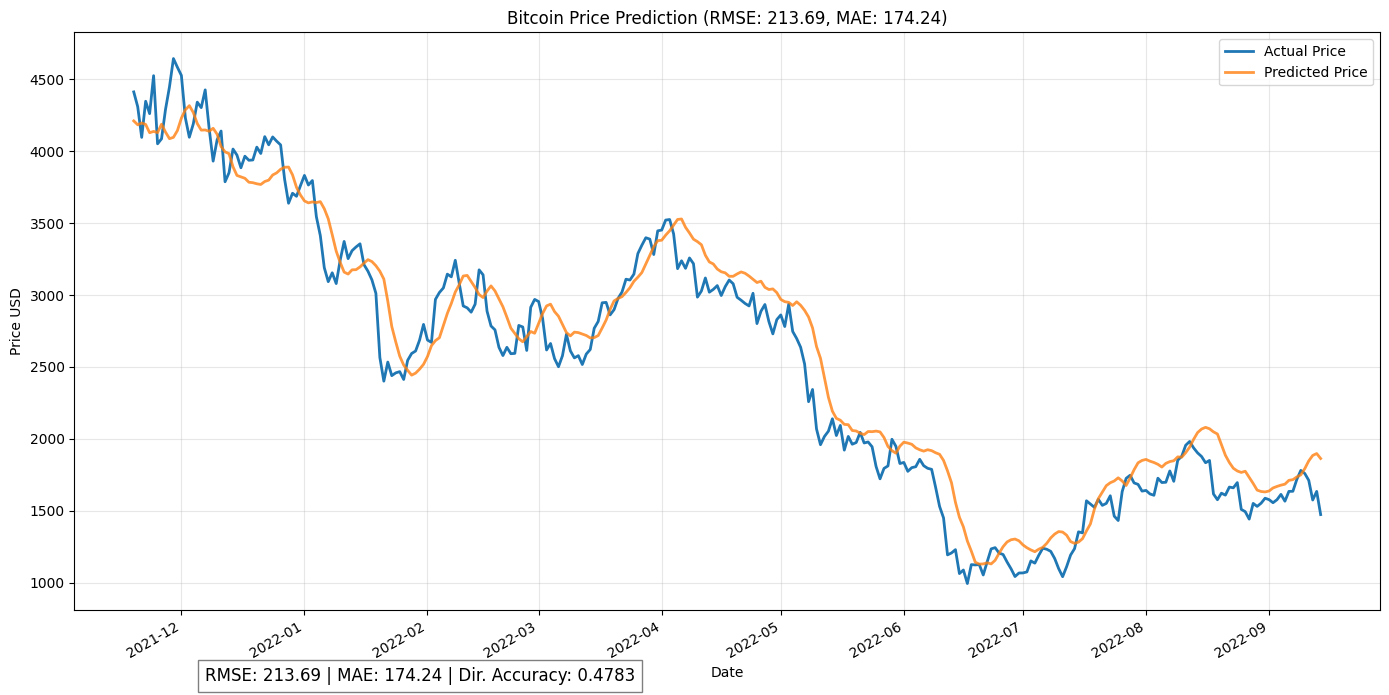

In [56]:
# # Visualizing the result
# import matplotlib.pyplot as plt

# # Visualize predictions
# plt.figure(figsize=(14, 7))
# plt.plot(y_test_actual, label='Actual Price', color='blue')
# plt.plot(y_pred, label='Predicted Price', color='red', linestyle='--')
# plt.title('Bitcoin Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Price USD')
# plt.legend()
# plt.grid(True)
# plt.show()

# After your predictions and metrics calculations:

# Get the dates for the test set
# We need to find the dates that correspond to our test set
test_dates = df['time'].iloc[-(len(y_test_actual)):]

# Visualizing the result with dates
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted Price', linewidth=2, alpha=0.8)
plt.title(f'Bitcoin Price Prediction (RMSE: {rmse:.2f}, MAE: {mae:.2f})')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.grid(alpha=0.3)

# Format x-axis to show dates properly
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Add text annotation for metrics
plt.figtext(0.15, 0.02, f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | Dir. Accuracy: {dir_acc:.4f}",
            ha="left", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.show()

In [58]:
# # Get the last 60 days of data (make sure to use all your features)
# last_60_days = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target',
#                   'MA_7', 'MA_30', 'MA_7_30_ratio', 'Volatility_30']].tail(time_steps).values

# Get the last 60 days of data (make sure to use all your features)
last_60_days = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD']].tail(time_steps).values

# Scale the data using your scaler_X
last_60_days_scaled = scaler_X.transform(last_60_days)

# Reshape for LSTM input (1 sample, 60 timesteps, n_features)
X_predict = last_60_days_scaled.reshape(1, time_steps, n_features)

# Make prediction
predicted_price_scaled = model.predict(X_predict)

# Inverse transform to get actual price
predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

print(f"Predicted Bitcoin Price: ${predicted_price[0][0]:.2f}")

# Compare with the last known price
last_actual_price = df['PriceUSD_target'].iloc[-1]
print(f"Last Known Price: ${last_actual_price:.2f}")
print(f"Predicted Change: {((predicted_price[0][0] - last_actual_price) / last_actual_price * 100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Bitcoin Price: $1848.51
Last Known Price: $1472.56
Predicted Change: 25.53%


In [60]:
# Function to predict multiple days ahead
# CHANGES DAYS_AHEAD FROM 7 TO 120
def predict_future(days_ahead=120):
    # Start with the last known sequence
    current_sequence = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD']].tail(time_steps).values

    current_sequence_scaled = scaler_X.transform(current_sequence)

    predictions = []

    for _ in range(days_ahead):
        # Reshape for prediction
        X_pred = current_sequence_scaled.reshape(1, time_steps, n_features)

        # Predict next price
        next_price_scaled = model.predict(X_pred, verbose=0)
        next_price = scaler_y.inverse_transform(next_price_scaled)[0][0]
        predictions.append(next_price)

        # Update sequence by adding the new prediction
        # This is a simplified approach - in reality you'd need to estimate other features too
        # new_row = current_sequence[-1].copy()
        # new_row[4] = scaler_y.inverse_transform(next_price_scaled)[0][0]  # Update PriceUSD_target
        # new_row = np.array([new_row])
        # new_row_scaled = scaler_X.transform(new_row)

        # Remove oldest day and add newest prediction
        # current_sequence_scaled = np.vstack([current_sequence_scaled[1:], new_row_scaled])

        # FIX: Replace the previous 3 lines with the following to update current_sequence directly:
        current_sequence = np.roll(current_sequence, -1, axis=0)  # Shift values up by one
        current_sequence[-1, 0] = next_price # Update the last element with the prediction
        current_sequence_scaled = scaler_X.transform(current_sequence)


    return predictions

# Predict prices for the next 60 days
future_prices = predict_future(60)
print("Predicted prices for the next 7 days:")
for i, price in enumerate(future_prices):
    print(f"Day {i+1}: ${price:.2f}")

Predicted prices for the next 7 days:
Day 1: $1848.51
Day 2: $1621.40
Day 3: $1535.86
Day 4: $1488.55
Day 5: $1458.64
Day 6: $1461.70
Day 7: $1462.26
Day 8: $1476.05
Day 9: $1502.84
Day 10: $1476.10
Day 11: $1435.12
Day 12: $1508.59
Day 13: $1582.11
Day 14: $1632.81
Day 15: $1648.89
Day 16: $1654.81
Day 17: $1640.32
Day 18: $1639.58
Day 19: $1628.33
Day 20: $1605.71
Day 21: $1647.33
Day 22: $1665.26
Day 23: $1675.79
Day 24: $1708.13
Day 25: $1708.27
Day 26: $1744.03
Day 27: $1783.91
Day 28: $1831.40
Day 29: $1870.56
Day 30: $1883.67
Day 31: $1883.64
Day 32: $1867.66
Day 33: $1840.58
Day 34: $1822.84
Day 35: $1744.53
Day 36: $1675.90
Day 37: $1642.82
Day 38: $1619.49
Day 39: $1619.66
Day 40: $1622.39
Day 41: $1636.71
Day 42: $1596.02
Day 43: $1559.28
Day 44: $1518.07
Day 45: $1522.48
Day 46: $1528.20
Day 47: $1539.20
Day 48: $1562.58
Day 49: $1574.42
Day 50: $1577.75
Day 51: $1581.77
Day 52: $1605.27
Day 53: $1605.99
Day 54: $1626.26
Day 55: $1642.91
Day 56: $1682.10
Day 57: $1731.45
Da

In [61]:
# # Install the missing dependency
# %pip install tabulate

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Metric': ['Total Data Points', 'Training Data Points', 'Testing Data Points',
               'RMSE', 'MAE', 'Directional Accuracy',
               'First Actual Price', 'First Predicted Price',
               'Last Actual Price', 'Last Predicted Price', 'Predicted Future Price'],
    'Value': [len(df), len(X_train), len(X_test),
              rmse, mae, dir_acc,
              y_test_actual[0][0], y_pred[0][0],
              y_test_actual[-1][0], y_pred[-1][0], predicted_price[0][0]]
})

# Display in markdown format
print(results_df.to_markdown(index=False))

| Metric                 |       Value |
|:-----------------------|------------:|
| Total Data Points      | 2054        |
| Training Data Points   | 1395        |
| Testing Data Points    |  300        |
| RMSE                   |  213.689    |
| MAE                    |  174.242    |
| Directional Accuracy   |    0.478261 |
| First Actual Price     | 4413.14     |
| First Predicted Price  | 4211.45     |
| Last Actual Price      | 1472.56     |
| Last Predicted Price   | 1862.57     |
| Predicted Future Price | 1848.51     |


Predicted Bitcoin Price: $44185.15
Last Known Price: $44941.16
Predicted Change: -1.68%
Saved future_predictions.csv!


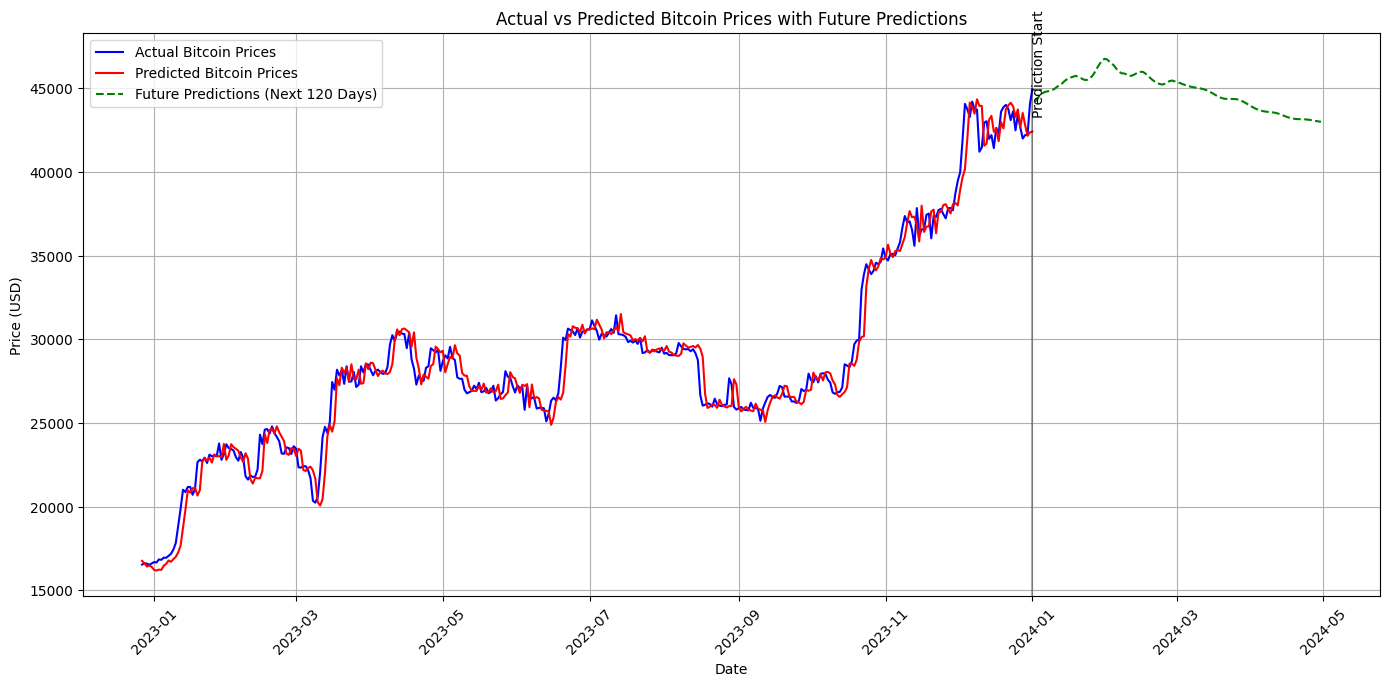

In [25]:
# First, we need to generate future dates
# CHANGES:
# changing the period from 60 to 120
last_date = df['time'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=120, freq='D')

# Get future predictions (using the function from earlier)
future_predictions = predict_future(days_ahead=120)

# Plotting future predictions alongside actual prices
plt.figure(figsize=(14, 7))

# Get the actual dates for the test set
test_dates = df['time'].iloc[-len(y_test_actual):]

# Plot actual prices with dates
plt.plot(test_dates, y_test_actual, label='Actual Bitcoin Prices', color='blue')

# Plot predicted prices for test period
plt.plot(test_dates, y_pred, label='Predicted Bitcoin Prices', color='red')


# Future Predictions
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 120 Days)',
         color='green', linestyle='--')

predicted_price = scaler_y.inverse_transform(predicted_price_scaled)

print(f"Predicted Bitcoin Price: ${predicted_price[0][0]:.2f}")

# Compare with the last known price
last_actual_price = df['PriceUSD_target'].iloc[-1]
print(f"Last Known Price: ${last_actual_price:.2f}")
print(f"Predicted Change: {((predicted_price[0][0] - last_actual_price) / last_actual_price * 100):.2f}%")

# Add a vertical line to mark where predictions start
plt.axvline(x=last_date, color='black', linestyle='-', alpha=0.3)
plt.text(last_date, plt.ylim()[1]*0.9, 'Prediction Start', rotation=90)

import pandas as pd
import numpy as np

# Make sure future_predictions is a 1D array or list
# If it's a nested list like [[x], [y], …], first unpack it:
if isinstance(future_predictions, list) and isinstance(future_predictions[0], (list, np.ndarray)):
    flat_preds = [p[0] for p in future_predictions]
else:
    flat_preds = np.array(future_predictions).reshape(-1)

# Build DataFrame
future_df = pd.DataFrame({
    'date': future_dates,
    'predicted_price_usd': flat_preds
})

# Save to CSV
future_df.to_csv('future_predictions.csv', index=False)
print("Saved future_predictions.csv!")


# Plotting
plt.title('Actual vs Predicted Bitcoin Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
#
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')
# metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2023-01-01", end_time="2024-01-02", frequency='1d')
metrics_eth = client.get_asset_metrics(assets='eth', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2017-01-01", end_time="2024-01-02", frequency='1d')

In [40]:
# Assuming client = CoinMetricsClient()
metrics_eth['time'] = pd.to_datetime(metrics_eth['time'])
metrics_eth.sort_values('time', inplace=True)

# Create features
metrics_eth['PriceUSD_target'] = metrics_eth['PriceUSD'].shift(-1)
metrics_eth.dropna(inplace=True)

# Select same features used in training
X_eth = metrics_eth[['PriceUSD']].values
y_eth = metrics_eth['PriceUSD_target'].values

# Scale with the SAME scaler (important!)
X_eth_scaled = scaler_X.transform(X_eth)
y_eth_scaled = scaler_y.transform(y_eth.reshape(-1, 1))


In [41]:
time_steps = 60  # or whatever you used for Bitcoin

def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

X_eth_seq, y_eth_seq = create_sequences(X_eth_scaled, y_eth_scaled, time_steps)


In [42]:
# Predict ETH using Bitcoin-trained model
y_pred_eth_scaled = model.predict(X_eth_seq)

# Inverse transform to get actual prices
y_pred_eth = scaler_y.inverse_transform(y_pred_eth_scaled)
y_eth_actual = scaler_y.inverse_transform(y_eth_seq.reshape(-1, 1))

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

eth_rmse = np.sqrt(mean_squared_error(y_eth_actual, y_pred_eth))
eth_mae = mean_absolute_error(y_eth_actual, y_pred_eth)

print(f"ETH Testing RMSE: {eth_rmse:.2f}")
print(f"ETH Testing MAE: {eth_mae:.2f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
ETH Testing RMSE: 124.95
ETH Testing MAE: 68.80


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
ETH Testing RMSE: 124.95
ETH Testing MAE: 68.80


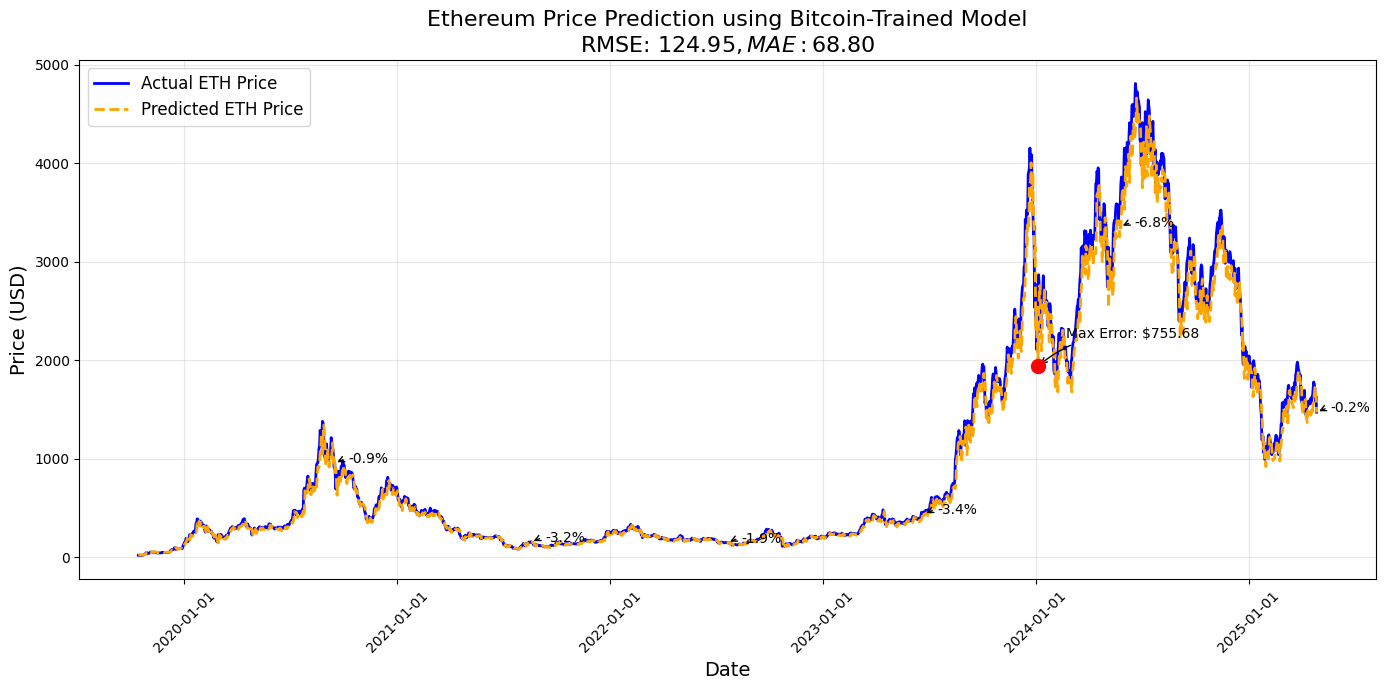

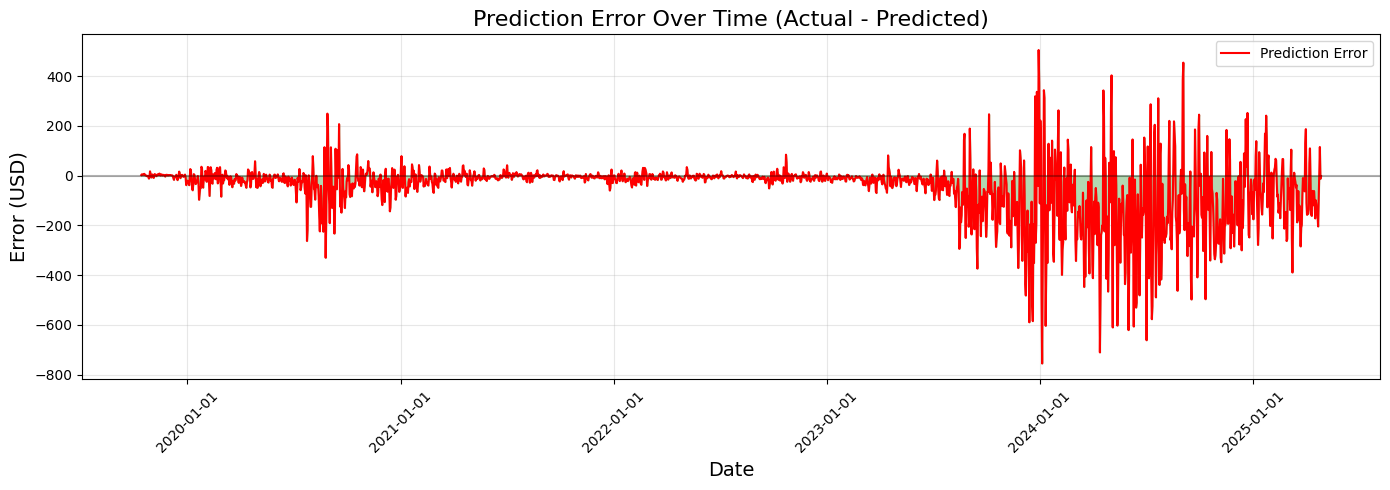

In [44]:
# Predict ETH using Bitcoin-trained model
y_pred_eth_scaled = model.predict(X_eth_seq)

# Inverse transform to get actual prices
y_pred_eth = scaler_y.inverse_transform(y_pred_eth_scaled)
y_eth_actual = scaler_y.inverse_transform(y_eth_seq.reshape(-1, 1))

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

eth_rmse = np.sqrt(mean_squared_error(y_eth_actual, y_pred_eth))
eth_mae = mean_absolute_error(y_eth_actual, y_pred_eth)
print(f"ETH Testing RMSE: {eth_rmse:.2f}")
print(f"ETH Testing MAE: {eth_mae:.2f}")

# Create date range for x-axis (if you have actual dates, use those instead)
# This assumes your test data represents consecutive days
# If you have actual dates in your DataFrame, use those instead
try:
    # Attempt to get actual dates if available in your data
    dates = eth_data.iloc[-len(y_eth_actual):]['time'].values
except:
    # If not available, create a date range
    dates = pd.date_range(end=pd.Timestamp.today(), periods=len(y_eth_actual))

# Create a visualization
plt.figure(figsize=(14, 7))

# Plot the actual and predicted prices
plt.plot(dates, y_eth_actual, label='Actual ETH Price', color='blue', linewidth=2)
plt.plot(dates, y_pred_eth, label='Predicted ETH Price', color='orange', linewidth=2, linestyle='--')

# Add a vertical line to indicate the end of training data if applicable
# plt.axvline(x=train_end_date, color='red', linestyle='-', alpha=0.3, label='Train-Test Split')

# Add graph elements
plt.title(f'Ethereum Price Prediction using Bitcoin-Trained Model\nRMSE: ${eth_rmse:.2f}, MAE: ${eth_mae:.2f}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add annotations showing percentage error at a few points
n_points = 5  # Number of points to annotate
step = len(y_eth_actual) // (n_points + 1)
for i in range(step, len(y_eth_actual), step):
    error_pct = (y_pred_eth[i][0] - y_eth_actual[i][0]) / y_eth_actual[i][0] * 100
    plt.annotate(f'{error_pct:.1f}%',
                 xy=(dates[i], y_pred_eth[i][0]),
                 xytext=(10, 0), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Show the max and min prediction errors
max_error_idx = np.abs(y_pred_eth - y_eth_actual).argmax()
plt.scatter(dates[max_error_idx], y_pred_eth[max_error_idx], color='red', s=100, zorder=5)
plt.annotate(f'Max Error: ${abs(y_pred_eth[max_error_idx][0] - y_eth_actual[max_error_idx][0]):.2f}',
             xy=(dates[max_error_idx], y_pred_eth[max_error_idx]),
             xytext=(20, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.savefig('eth_price_prediction.png', dpi=300)
plt.show()

# Additional plot: Error over time
plt.figure(figsize=(14, 5))
prediction_error = (y_pred_eth - y_eth_actual).reshape(-1)
plt.plot(dates, prediction_error, color='red', label='Prediction Error')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(dates, prediction_error, 0, alpha=0.3, color='red' if np.mean(prediction_error) > 0 else 'green')
plt.title('Prediction Error Over Time (Actual - Predicted)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Error (USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('eth_prediction_error.png', dpi=300)
plt.show()